# Watershed distance transform for 3-dimensional data

In [1]:
import os
import errno
import argparse

import numpy as np
from tensorflow.python.keras.optimizers import SGD, Adam
from tensorflow.python.keras import backend as K

from deepcell import get_data
from deepcell import make_training_data
from deepcell import rate_scheduler
from deepcell.model_zoo import bn_feature_net_3D
from deepcell.model_zoo import bn_feature_net_61x61_3D
from deepcell.model_zoo import dilated_bn_feature_net_61x61_3D
from deepcell.training import train_model_movie
from deepcell.training import train_model_sample_movie
from deepcell.training import train_model_watershed_3D

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Conv Based Training

In [2]:
DATA_OUTPUT_MODE = 'conv'
BORDER_MODE = 'same'
RESIZE = False
RESHAPE_SIZE = 256
NUM_FRAMES = 30  # get first N frames from each training folder
BINS = 4  # number of distance bins to classify

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/MouseBrain/generic'
CONV_DATA_FILE = 'MouseBrain_3d_watershed_{}'.format(DATA_OUTPUT_MODE)

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'

ROW_AXIS = 3 if IS_CHANNELS_FIRST else 2
COL_AXIS = 4 if IS_CHANNELS_FIRST else 3
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else 4

# create these directories if they do not exist
for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
    try:
        os.makedirs(os.path.join(d, PREFIX))
        print('Created new directory:', os.path.join(d, PREFIX))
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [3]:
# Create the training data
make_training_data(
    dimensionality=3,
    direc_name=os.path.join(DATA_DIR, PREFIX),
    file_name_save=os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE),
    channel_names=['slice'],  # for iterating over stacks of images from a montage
    training_direcs=['set6'],
    output_mode=DATA_OUTPUT_MODE,
    window_size_x=30,
    window_size_y=30,
    window_size_z=3,
    border_mode=BORDER_MODE,
    reshape_size=None if not RESIZE else RESHAPE_SIZE,
    process=True,
    process_std=True,
    display=False,
    num_frames=NUM_FRAMES,
    num_of_frames_to_display=5,
    verbose=True,
    montage_mode=True,  # annotation folder has montaged sub-dirs
    annotation_name='',  # basically channel name but for annotated images
    raw_image_direc='stacked_raw',
    annotation_direc='annotated/all_montages')

if os.path.isfile(os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE) + '.npz'):
    print('\nData saved to', os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')

Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_0_y_0, as num_frames is 30 but there are 41 total frames
Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_0_y_1, as num_frames is 30 but there are 41 total frames
Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_0_y_2, as num_frames is 30 but there are 41 total frames
Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_0_y_3, as num_frames is 30 but there are 41 total frames
Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_1_y_0, as num_frames is 30 but there are 41 total frames
Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_1_y_1, as num_frames is 30 but there are 41 total frames
Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_1_y_2, as num_frames is 30 but there are 4

In [4]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# Set up training parameters
n_epoch = 32
batch_size = 1
frames_per_batch = 10
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.95)

# save the size of the input data for batch_shape model parameter
size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    batch_shape = (batch_size, X.shape[CHANNEL_AXIS], frames_per_batch, size[0], size[1])
else:
    batch_shape = (batch_size, frames_per_batch, size[0], size[1], X.shape[CHANNEL_AXIS])

X.shape: (16, 30, 256, 256, 1)
y.shape: (16, 30, 256, 256, 1)


In [5]:
# First, create a foreground/background separation model

# Instantiate the model
fgbg_model = bn_feature_net_3D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    batch_shape=batch_shape,
    norm_method='whole_image')

# Train the model
train_model_movie(
    model=fgbg_model,
    expt='fgbg',
    dataset=CONV_DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    frames_per_batch=frames_per_batch,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=rate_scheduler(lr=0.01, decay=0.95),
    rotation_range=180,
    flip=True,
    shear=0)

X_train shape: (14, 30, 256, 256, 1)
y_train shape: (14, 30, 256, 256, 1)
X_test shape: (2, 30, 256, 256, 1)
y_test shape: (2, 30, 256, 256, 1)
Output Shape: (1, 10, 256, 256, 2)
Number of Classes: 2
Using real-time data augmentation.
Epoch 1/32
41/42 [============================>.] - ETA: 1s - loss: 0.2242 - acc: 0.9049
Epoch 00001: val_loss improved from inf to 0.33852, saving model to /data/models/cells/MouseBrain/generic/2018-08-01_MouseBrain_3d_watershed_conv_fgbg_0.h5
42/42 [==============================] - 60s 1s/step - loss: 0.2217 - acc: 0.9048 - val_loss: 0.3385 - val_acc: 0.9041
Epoch 2/32
41/42 [============================>.] - ETA: 0s - loss: 0.1439 - acc: 0.9285
Epoch 00002: val_loss improved from 0.33852 to 0.24719, saving model to /data/models/cells/MouseBrain/generic/2018-08-01_MouseBrain_3d_watershed_conv_fgbg_0.h5
42/42 [==============================] - 30s 713ms/step - loss: 0.1456 - acc: 0.9288 - val_loss: 0.2472 - val_acc: 0.9456
Epoch 3/32
41/42 [============

Epoch 29/32
41/42 [============================>.] - ETA: 0s - loss: 0.1081 - acc: 0.9380
Epoch 00029: val_loss did not improve
42/42 [==============================] - 30s 712ms/step - loss: 0.1077 - acc: 0.9387 - val_loss: 0.2160 - val_acc: 0.9221
Epoch 30/32
41/42 [============================>.] - ETA: 0s - loss: 0.1124 - acc: 0.9344
Epoch 00030: val_loss did not improve
42/42 [==============================] - 30s 713ms/step - loss: 0.1130 - acc: 0.9345 - val_loss: 0.1638 - val_acc: 0.9342
Epoch 31/32
41/42 [============================>.] - ETA: 0s - loss: 0.1146 - acc: 0.9385
Epoch 00031: val_loss did not improve
42/42 [==============================] - 30s 712ms/step - loss: 0.1143 - acc: 0.9387 - val_loss: 0.1958 - val_acc: 0.9260
Epoch 32/32
41/42 [============================>.] - ETA: 0s - loss: 0.1099 - acc: 0.9397
Epoch 00032: val_loss did not improve
42/42 [==============================] - 30s 714ms/step - loss: 0.1095 - acc: 0.9386 - val_loss: 0.2587 - val_acc: 0.9247


In [6]:
# Next, Create a model for the watershed energy transform

# Instantiate the model
watershed_model = bn_feature_net_3D(
    n_features=BINS,
    batch_shape=batch_shape,
    norm_method='whole_image')

# Train the model
train_model_watershed_3D(
    model=watershed_model,
    expt='watershed',
    dataset=CONV_DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    distance_bins=BINS,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (14, 30, 256, 256, 1)
y_train shape: (14, 30, 256, 256, 1)
X_test shape: (2, 30, 256, 256, 1)
y_test shape: (2, 30, 256, 256, 1)
Output Shape: (1, 10, 256, 256, 4)
Number of Classes: 4
Using real-time data augmentation.
Epoch 1/32
41/42 [============================>.] - ETA: 0s - loss: 0.3054 - acc: 0.8841
Epoch 00001: val_loss improved from inf to 0.40932, saving model to /data/models/cells/MouseBrain/generic/2018-08-01_MouseBrain_3d_watershed_conv_watershed_0.h5
42/42 [==============================] - 32s 763ms/step - loss: 0.3019 - acc: 0.8855 - val_loss: 0.4093 - val_acc: 0.9094
Epoch 2/32
41/42 [============================>.] - ETA: 0s - loss: 0.1486 - acc: 0.9442
Epoch 00002: val_loss improved from 0.40932 to 0.23255, saving model to /data/models/cells/MouseBrain/generic/2018-08-01_MouseBrain_3d_watershed_conv_watershed_0.h5
42/42 [==============================] - 30s 721ms/step - loss: 0.1479 - acc: 0.9445 - val_loss: 0.2325 - val_acc: 0.9337
Epoch 3/32
41/42 

Epoch 28/32
41/42 [============================>.] - ETA: 0s - loss: 0.1173 - acc: 0.9534
Epoch 00028: val_loss did not improve
42/42 [==============================] - 30s 718ms/step - loss: 0.1167 - acc: 0.9537 - val_loss: 0.1914 - val_acc: 0.9308
Epoch 29/32
41/42 [============================>.] - ETA: 0s - loss: 0.1208 - acc: 0.9522
Epoch 00029: val_loss did not improve
42/42 [==============================] - 30s 719ms/step - loss: 0.1211 - acc: 0.9518 - val_loss: 0.1471 - val_acc: 0.9528
Epoch 30/32
41/42 [============================>.] - ETA: 0s - loss: 0.1164 - acc: 0.9536
Epoch 00030: val_loss did not improve
42/42 [==============================] - 30s 718ms/step - loss: 0.1165 - acc: 0.9534 - val_loss: 0.1516 - val_acc: 0.9496
Epoch 31/32
41/42 [============================>.] - ETA: 0s - loss: 0.1166 - acc: 0.9550
Epoch 00031: val_loss did not improve
42/42 [==============================] - 30s 720ms/step - loss: 0.1161 - acc: 0.9551 - val_loss: 0.1827 - val_acc: 0.9375


In [7]:
# With the trained model, make predictions on testing data
training_data_file = os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE + '.npz')

train_dict, (X_test, y_test) = get_data(
    training_data_file, mode=DATA_OUTPUT_MODE, seed=21)

# To predict on variable number of frames
# we need to re-instantiate model and load weights
model_fn = bn_feature_net_3D
watershed_weights_file = '2018-08-01_MouseBrain_3d_watershed_conv_watershed_0.h5'
watershed_weights_file = os.path.join(MODEL_DIR, PREFIX, watershed_weights_file)

fg_bg_weights_file = '2018-08-01_MouseBrain_3d_watershed_conv_fgbg_0.h5'
fg_bg_weights_file = os.path.join(MODEL_DIR, PREFIX, fg_bg_weights_file)

fgbg_model = model_fn(n_features=2, batch_shape=X_test.shape, norm_method='whole_image')
fgbg_model.load_weights(fg_bg_weights_file)

watershed_model = model_fn(n_features=BINS, batch_shape=X_test.shape, norm_method='whole_image')
watershed_model.load_weights(watershed_weights_file)

In [8]:
test_images = watershed_model.predict(X_test)
test_images_fgbg = fgbg_model.predict(X_test)

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=CHANNEL_AXIS - 1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=CHANNEL_AXIS)

print('watershed argmax shape:', argmax_images.shape)

watershed transform shape: (2, 30, 256, 256, 4)
segmentation mask shape: (2, 30, 256, 256, 2)
watershed argmax shape: (2, 30, 256, 256, 1)


In [9]:
# threshold the foreground/background
# and remove back ground from watershed transform
threshold = 0.8
if IS_CHANNELS_FIRST:
    fg_thresh = test_images_fgbg[:, 1, :, :, :] > threshold
else:
    fg_thresh = test_images_fgbg[:, :, :, :, 1] > threshold

fg_thresh = np.expand_dims(fg_thresh, axis=CHANNEL_AXIS)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [10]:
# Apply watershed method with the distance transform as seed
from scipy import ndimage
from skimage.morphology import watershed
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    if IS_CHANNELS_FIRST:
        image = fg_thresh[i, 0, :, :, :]
        distance = argmax_images_post_fgbg[i, 0, :, :, :]
    else:
        image = fg_thresh[i, :, :, :, 0]
        distance = argmax_images_post_fgbg[i, :, :, :, 0]

    local_maxi = peak_local_max(
        distance,
        min_distance=20,
        indices=False,
        labels=image,
        exclude_border=False)

    markers = ndimage.label(local_maxi)[0]
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=CHANNEL_AXIS)

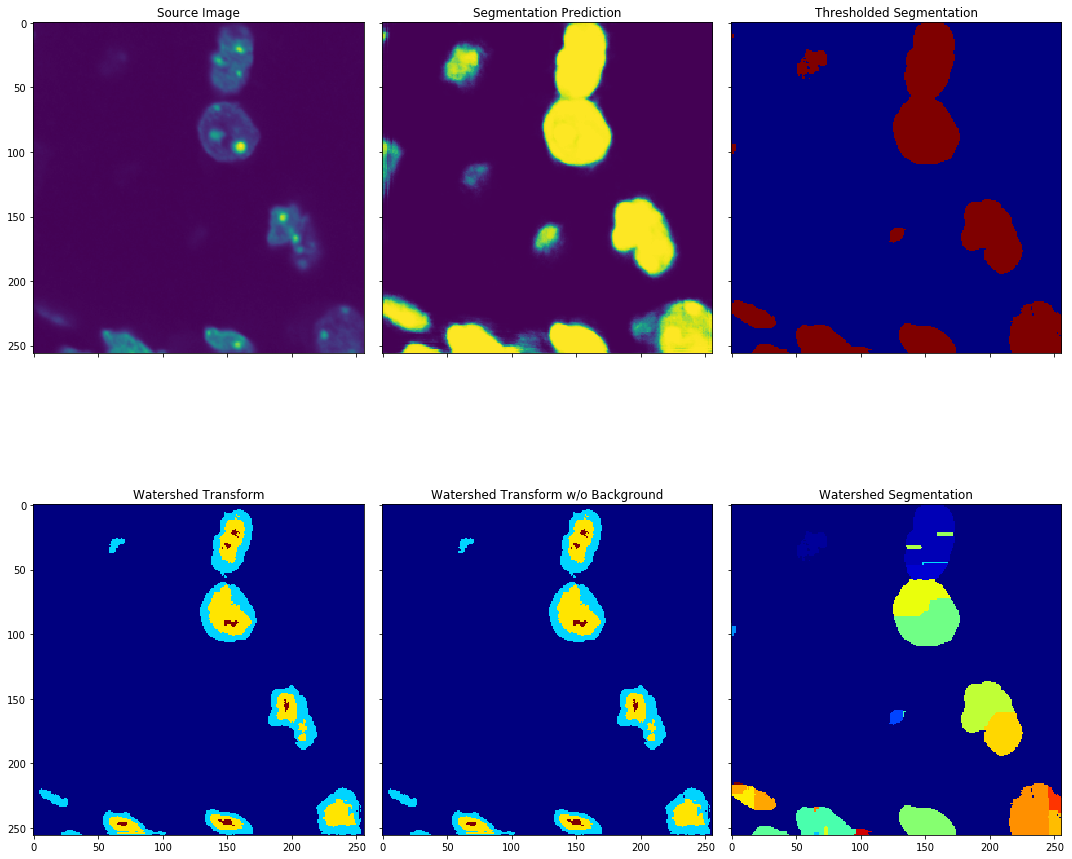

In [11]:
# Plot the results
import matplotlib.pyplot as plt
import matplotlib.animation as animation

index = 0
frame = 8

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, :, :, 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, :, :, 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, :, :, 0], cmap='jet')
ax[2].set_title('Thresholded Segmentation')

ax[3].imshow(argmax_images[index, frame, :, :, 0], cmap='jet')
ax[3].set_title('Watershed Transform')

ax[4].imshow(argmax_images_post_fgbg[index, frame, :, :, 0], cmap='jet')
ax[4].set_title('Watershed Transform w/o Background')

ax[5].imshow(watershed_images[index, frame, :, :, 0], cmap='jet')
ax[5].set_title('Watershed Segmentation')

fig.tight_layout()
plt.show()

# Sample Based Training

In [12]:
DATA_OUTPUT_MODE = 'sample'
BORDER_MODE = 'valid'
RESIZE = False
RESHAPE_SIZE = 256
NUM_FRAMES = 30
BINS = 4

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/MouseBrain/generic'
WATERSHED_DATA_FILE = 'MouseBrain_3d_watershed_{}'.format(DATA_OUTPUT_MODE)
FG_BG_DATA_FILE = 'MouseBrain_3d_{}'.format(DATA_OUTPUT_MODE)

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'

# Set sample window size
WIN_X = 30
WIN_Y = 30
WIN_Z = 2

ROW_AXIS = 3 if IS_CHANNELS_FIRST else 2
COL_AXIS = 4 if IS_CHANNELS_FIRST else 3
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else 4

In [13]:
# Make the training data for foreground/background segmentation
make_training_data(
    dimensionality=3,
    direc_name=os.path.join(DATA_DIR, PREFIX),
    file_name_save=os.path.join(NPZ_DIR, PREFIX, FG_BG_DATA_FILE),
    channel_names=['slice'],  # for iterating over stacks of images from a montage
    training_direcs=['set6'],
    output_mode=DATA_OUTPUT_MODE,
    max_training_examples=1e5,
    window_size_x=WIN_X,
    window_size_y=WIN_Y,
    window_size_z=WIN_Z,
    border_mode=BORDER_MODE,
    reshape_size=None if not RESIZE else RESHAPE_SIZE,
    distance_transform=False,
    distance_bins=4,
    display=False,
    num_frames=NUM_FRAMES,
    num_of_frames_to_display=5,
    verbose=False,
    montage_mode=True,  # annotation folder has montaged sub-dirs
    annotation_name='',  # basically channel name but for annotated images
    raw_image_direc='stacked_raw',
    annotation_direc='annotated/all_montages')

if os.path.isfile(os.path.join(NPZ_DIR, PREFIX, FG_BG_DATA_FILE) + '.npz'):
    print('Data Saved to', os.path.join(NPZ_DIR, PREFIX, FG_BG_DATA_FILE) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')

Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_0_y_0, as num_frames is 30 but there are 41 total frames
Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_0_y_1, as num_frames is 30 but there are 41 total frames
Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_0_y_2, as num_frames is 30 but there are 41 total frames
Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_0_y_3, as num_frames is 30 but there are 41 total frames
Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_1_y_0, as num_frames is 30 but there are 41 total frames
Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_1_y_1, as num_frames is 30 but there are 41 total frames
Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_1_y_2, as num_frames is 30 but there are 4

In [14]:
# Make the training data for foreground/background segmentation
make_training_data(
    dimensionality=3,
    direc_name=os.path.join(DATA_DIR, PREFIX),
    file_name_save=os.path.join(NPZ_DIR, PREFIX, WATERSHED_DATA_FILE),
    channel_names=['slice'],  # for iterating over stacks of images from a montage
    training_direcs=['set6'],
    output_mode=DATA_OUTPUT_MODE,
    max_training_examples=1e5,
    window_size_x=WIN_X,
    window_size_y=WIN_Y,
    window_size_z=WIN_Z,
    border_mode=BORDER_MODE,
    reshape_size=None if not RESIZE else RESHAPE_SIZE,
    distance_transform=True,
    distance_bins=4,
    display=False,
    num_frames=NUM_FRAMES,
    num_of_frames_to_display=5,
    verbose=False,
    montage_mode=True,  # annotation folder has montaged sub-dirs
    annotation_name='',  # basically channel name but for annotated images
    raw_image_direc='stacked_raw',
    annotation_direc='annotated/all_montages')

if os.path.isfile(os.path.join(NPZ_DIR, PREFIX, WATERSHED_DATA_FILE) + '.npz'):
    print('Data Saved to', os.path.join(NPZ_DIR, PREFIX, WATERSHED_DATA_FILE) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')

Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_0_y_0, as num_frames is 30 but there are 41 total frames
Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_0_y_1, as num_frames is 30 but there are 41 total frames
Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_0_y_2, as num_frames is 30 but there are 41 total frames
Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_0_y_3, as num_frames is 30 but there are 41 total frames
Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_1_y_0, as num_frames is 30 but there are 41 total frames
Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_1_y_1, as num_frames is 30 but there are 41 total frames
Skipped final 11 frames of /data/data/cells/MouseBrain/generic/set6/stacked_raw/set_6_x_1_y_2, as num_frames is 30 but there are 4

In [15]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, FG_BG_DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# Set up training parameters
n_epoch = 8
batch_size = 64
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

X.shape: (16, 30, 256, 256, 1)
y.shape: (100000,)


In [16]:
# First, create a foreground/background separation model

# Instantiate the model
fgbg_model = bn_feature_net_61x61_3D(
    n_features=2,
    n_frames=2 * WIN_Z + 1,
    n_channels=X.shape[CHANNEL_AXIS])

# Train the model
train_model_sample_movie(
    model=fgbg_model,
    dataset=FG_BG_DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    expt='fgbg',
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (90000, 5, 61, 61, 1)
y_train shape: (90000,)
X_test shape: (10000, 5, 61, 61, 1)
y_test shape: (10000,)
Output Shape: (None, 2)
Number of Classes: 2
Using real-time data augmentation.
Epoch 1/8
1405/1406 [============================>.] - ETA: 0s - loss: 0.1788 - acc: 0.9242
Epoch 00001: val_loss improved from inf to 0.17747, saving model to /data/models/cells/MouseBrain/generic/2018-08-01_MouseBrain_3d_sample_fgbg_0.h5
1406/1406 [==============================] - 185s 132ms/step - loss: 0.1788 - acc: 0.9242 - val_loss: 0.1775 - val_acc: 0.9300
Epoch 2/8
1405/1406 [============================>.] - ETA: 0s - loss: 0.1539 - acc: 0.9349
Epoch 00002: val_loss did not improve
1406/1406 [==============================] - 176s 125ms/step - loss: 0.1539 - acc: 0.9349 - val_loss: 0.2038 - val_acc: 0.9494
Epoch 3/8
1405/1406 [============================>.] - ETA: 0s - loss: 0.1491 - acc: 0.9378
Epoch 00003: val_loss improved from 0.17747 to 0.16561, saving model to /data/models

In [17]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, WATERSHED_DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# Set up training parameters
n_epoch = 8
batch_size = 64
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

X.shape: (16, 30, 256, 256, 1)
y.shape: (100000,)


In [18]:
# Next, Create a model for the watershed energy transform

# Instantiate the model
watershed_model = bn_feature_net_61x61_3D(
    n_features=BINS,
    n_frames=2 * WIN_Z + 1,
    n_channels=X.shape[CHANNEL_AXIS])

# Train the model
train_model_sample_movie(
    model=watershed_model,
    dataset=WATERSHED_DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    expt='watershed',
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (90000, 5, 61, 61, 1)
y_train shape: (90000,)
X_test shape: (10000, 5, 61, 61, 1)
y_test shape: (10000,)
Output Shape: (None, 4)
Number of Classes: 4
Using real-time data augmentation.
Epoch 1/8
1405/1406 [============================>.] - ETA: 0s - loss: 0.4308 - acc: 0.8761
Epoch 00001: val_loss improved from inf to 0.37727, saving model to /data/models/cells/MouseBrain/generic/2018-08-01_MouseBrain_3d_watershed_sample_watershed_0.h5
1406/1406 [==============================] - 180s 128ms/step - loss: 0.4306 - acc: 0.8761 - val_loss: 0.3773 - val_acc: 0.9322
Epoch 2/8
1405/1406 [============================>.] - ETA: 0s - loss: 0.3651 - acc: 0.9026
Epoch 00002: val_loss improved from 0.37727 to 0.33472, saving model to /data/models/cells/MouseBrain/generic/2018-08-01_MouseBrain_3d_watershed_sample_watershed_0.h5
1406/1406 [==============================] - 178s 127ms/step - loss: 0.3650 - acc: 0.9026 - val_loss: 0.3347 - val_acc: 0.9130
Epoch 3/8
1405/1406 [===========

In [19]:
# With the trained models, make predictions on testing data
training_data_file = os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE + '.npz')

train_dict, (X_test, y_test) = get_data(
    training_data_file, mode='conv', seed=21)

# Re-initializing dilated models for sample-mode predictions
watershed_weights_file = '2018-08-01_MouseBrain_3d_watershed_sample_watershed_0.h5'
watershed_weights_file = os.path.join(MODEL_DIR, PREFIX, watershed_weights_file)

fg_bg_weights_file = '2018-08-01_MouseBrain_3d_sample_fgbg_0.h5'
fg_bg_weights_file = os.path.join(MODEL_DIR, PREFIX, fg_bg_weights_file)

run_watershed_model = dilated_bn_feature_net_61x61_3D(
    n_features=BINS,
    n_frames=2 * WIN_Z + 1,
    input_shape=X_test.shape[1:])
run_watershed_model.load_weights(watershed_weights_file)

run_fgbg_model = dilated_bn_feature_net_61x61_3D(
    n_features=2,
    n_frames=2 * WIN_Z + 1,
    input_shape=X_test.shape[1:])
run_fgbg_model.load_weights(fg_bg_weights_file)

In [20]:
# With the trained models, make predictions on testing data
test_images = run_watershed_model.predict(X_test)
test_images_fgbg = run_fgbg_model.predict(X_test)

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=CHANNEL_AXIS - 1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=CHANNEL_AXIS)

print('watershed argmax shape:', argmax_images.shape)

watershed transform shape: (2, 26, 196, 196, 4)
segmentation mask shape: (2, 26, 196, 196, 2)
watershed argmax shape: (2, 26, 196, 196, 1)


In [21]:
# threshold the foreground/background
# and remove back ground from watershed transform
threshold = 0.8
if IS_CHANNELS_FIRST:
    fg_thresh = test_images_fgbg[:, 1, :, :, :] > threshold
else:
    fg_thresh = test_images_fgbg[:, :, :, :, 1] > threshold

fg_thresh = np.expand_dims(fg_thresh, axis=CHANNEL_AXIS)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [22]:
# Apply watershed method with the distance transform as seed
from scipy import ndimage
from skimage.morphology import watershed
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    if IS_CHANNELS_FIRST:
        image = fg_thresh[i, 0, :, :, :]
        distance = argmax_images_post_fgbg[i, 0, :, :, :]
    else:
        image = fg_thresh[i, :, :, :, 0]
        distance = argmax_images_post_fgbg[i, :, :, :, 0]

    local_maxi = peak_local_max(
        distance,
        min_distance=20,
        indices=False,
        labels=image,
        exclude_border=False)

    markers = ndimage.label(local_maxi)[0]
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=CHANNEL_AXIS)

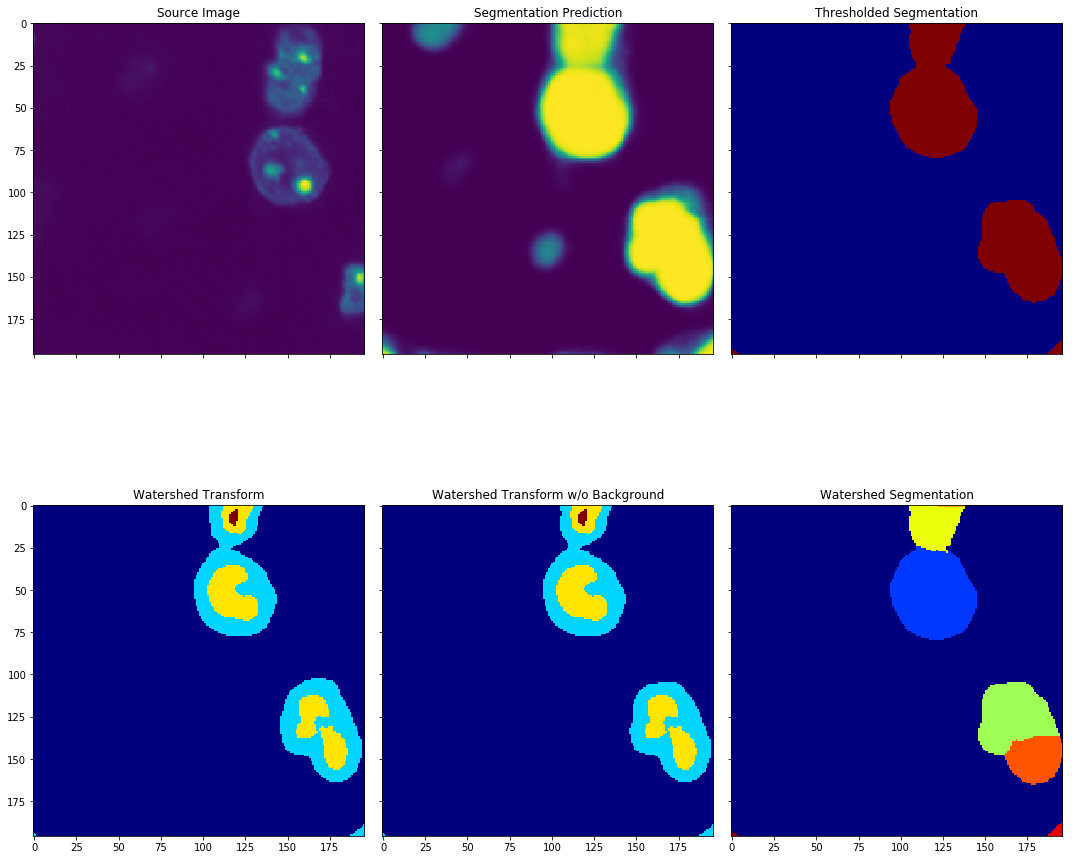

In [23]:
# Plot the results
import matplotlib.pyplot as plt
import matplotlib.animation as animation

index = 0
frame = 8

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, :, :, 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, :, :, 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, :, :, 0], cmap='jet')
ax[2].set_title('Thresholded Segmentation')

ax[3].imshow(argmax_images[index, frame, :, :, 0], cmap='jet')
ax[3].set_title('Watershed Transform')

ax[4].imshow(argmax_images_post_fgbg[index, frame, :, :, 0], cmap='jet')
ax[4].set_title('Watershed Transform w/o Background')

ax[5].imshow(watershed_images[index, frame, :, :, 0], cmap='jet')
ax[5].set_title('Watershed Segmentation')

fig.tight_layout()
plt.show()